In [1]:
# from preproc_tools import get_fr_by_sample, to_python_hdf5
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import json
from pathlib import Path
import h5py
from sklearn.svm import SVC
from datetime import datetime
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.results import Results
from ephysvibe.trials import  select_trials
from ephysvibe.trials.spikes import firing_rate
from typing import Dict, List
import tools_decoding
seed=1997

In [2]:
def define_contour_latencies(data, thresh):
        
    X,Y = np.where(data>=thresh)
    A=np.zeros(data.shape)
    A[X,Y]=1
    Ya,Xa    =   np.where(np.abs(np.diff(A, axis=0))!=0)
    Yb,Xb    =   np.where(np.abs(np.diff(A, axis=1))!=0)
    Yy  =   np.concatenate([Ya, Yb])
    Xx  =   np.concatenate([Xa, Xb])
    return Xx,Yy

In [3]:
def plot_grid_heatmap(mean_data,lat_data):
    xt_t = [40,85]
    xt_s = [20,65]
    label_t = ['0','450']
    label_s = ['0','450']

    samp_limit=20+65
    test_limit=105
    sample_r=int(samp_limit/10)
    test_r=int(test_limit/10)
    total_dim=(sample_r+test_r+1, sample_r+test_r+5)
    panel_dim=sample_r+test_r+1+5

    imcb0= plt.subplot2grid(shape=total_dim,  loc=(0, sample_r+test_r), colspan=1, rowspan=sample_r+test_r)

    im00 = plt.subplot2grid(shape=total_dim, loc=(0, 0), colspan=sample_r, rowspan=test_r)
    xx,yy=define_contour_latencies(lat_data[test_limit:,:samp_limit], thresh=950)
    sns.heatmap(mean_data[test_limit:,:samp_limit],ax=im00,cmap='viridis',vmin=0,vmax=1,cbar_ax=imcb0, linewidth=0,rasterized=True)
    im00.scatter(xx,yy,s=0.5,color = '#F9B233')
    im00.axes.invert_yaxis()

    im01 = plt.subplot2grid(shape=total_dim, loc=(0, sample_r), colspan=test_r, rowspan=test_r)
    xx,yy=define_contour_latencies(lat_data[test_limit:,test_limit:], thresh=950)
    sns.heatmap(mean_data[test_limit:,test_limit:],ax=im01,cmap='viridis',vmin=0,vmax=1,cbar=False, linewidth=0,rasterized=True)
    im01.scatter(xx,yy,s=0.5,color = '#F9B233')
    im01.axes.invert_yaxis()


    im10 = plt.subplot2grid(shape=total_dim, loc=(test_r, 0), colspan=sample_r, rowspan=sample_r)
    xx,yy=define_contour_latencies(lat_data[:samp_limit,:samp_limit], thresh=950)
    sns.heatmap(mean_data[:samp_limit,:samp_limit],ax=im10,cmap='viridis',vmin=0,vmax=1,cbar=False, linewidth=0,rasterized=True)
    im10.scatter(xx,yy,s=0.5,color = '#F9B233')
    im10.axes.invert_yaxis()

    im11 = plt.subplot2grid(shape=total_dim, loc=(test_r, sample_r), colspan=test_r, rowspan=sample_r)
    xx,yy=define_contour_latencies(lat_data[:samp_limit,test_limit:], thresh=950)
    sns.heatmap(mean_data[:samp_limit,test_limit:],ax=im11,cmap='viridis',vmin=0,vmax=1,cbar=False, linewidth=0,rasterized=True)
    im11.scatter(xx,yy,s=0.5,color = '#F9B233')
    im11.axes.invert_yaxis()

    im00.vlines(xt_s,0,200,'#444444','--',linewidth=1)
    im00.hlines(xt_t,0,200,'#444444','--',linewidth=1)
    im10.vlines(xt_s,0,200,'#444444','--',linewidth=1)
    im10.hlines(xt_s,0,200,'#444444','--',linewidth=1)
    im11.vlines(xt_t,0,200,'#444444','--',linewidth=1)
    im11.hlines(xt_s,0,200,'#444444','--',linewidth=1)
    im01.vlines(xt_t,0,200,'#444444','--',linewidth=1)
    im01.hlines(xt_t,0,200,'#444444','--',linewidth=1)

    im00.set_xticks([])
    im00.set_yticks(xt_t)
    im01.set_xticks([])
    im01.set_yticks([])
    im10.set_xticks(xt_s)
    im10.set_yticks(xt_s)
    im11.set_xticks(xt_t)
    im11.set_yticks([])

    im00.set_yticklabels(label_t)
    im10.set_xticklabels(label_s)
    im10.set_yticklabels(label_s)
    im11.set_xticklabels(label_t)
    im00.set_yticklabels(label_t)
    im10.set_xticklabels(label_s)
    im10.set_yticklabels(label_s)
    im11.set_xticklabels(label_t)


    return [im00, im01, im10, im11, imcb0]

In [ ]:
plt.close()

### Plot results from min_amount_cells.py

In [ ]:
path=(f'/envau/work/invibe/USERS/LOSADA/Users/losadac/decoder')
for ncells in [474,464,454,444]:
    for to_decode in ['orient']:   
        totatest = 20
        if to_decode=='sampleid':totatest=40
        res = Results.from_python_hdf5(f'{path}/q0.5_{ncells}cells_c0.001_test_orient.h5')
        data=res.perf.transpose(0,2,1)
        lat_data = np.sum(data>10,axis=0)
        mean_data = np.mean(data,axis=0)/totatest
        # Create and capture fig1
        fig = plt.figure(figsize=(5, 5))
        plot_grid_heatmap(mean_data,lat_data)
        fig.suptitle(res.n_cells)
          

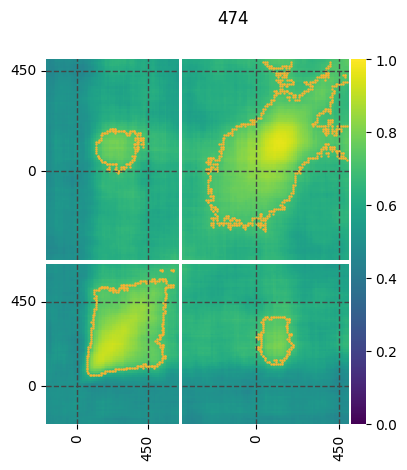

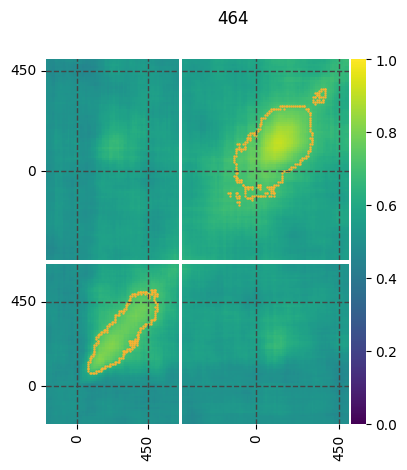

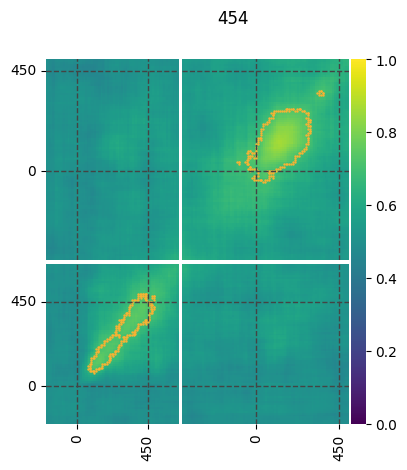

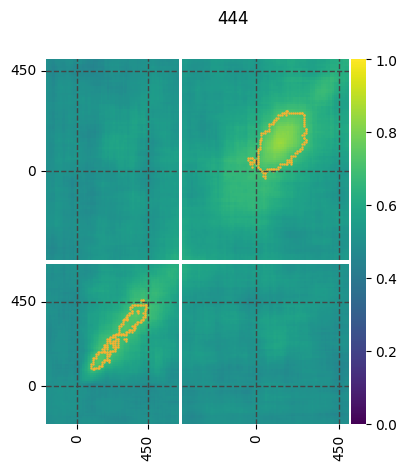

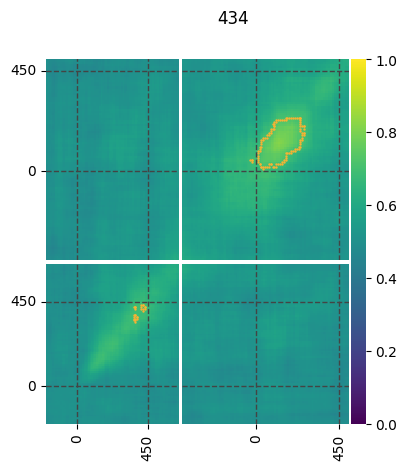

In [12]:
path=(f'/envau/work/invibe/USERS/LOSADA/Users/losadac/decoder/all_cells_c0.001')
for ncells in [474,464,454,444,434]:
    for to_decode in ['orient']:   
        totatest = 20
        if to_decode=='sampleid':totatest=40
        res = Results.from_python_hdf5(f'{path}/{ncells}cells_c0.001_test_orient.h5')
        data=res.perf.transpose(0,2,1)
        lat_data = np.sum(data>10,axis=0)
        mean_data = np.mean(data,axis=0)/totatest
        # Create and capture fig1
        fig = plt.figure(figsize=(5, 5))
        plot_grid_heatmap(mean_data,lat_data)
        fig.suptitle(res.n_cells)
                

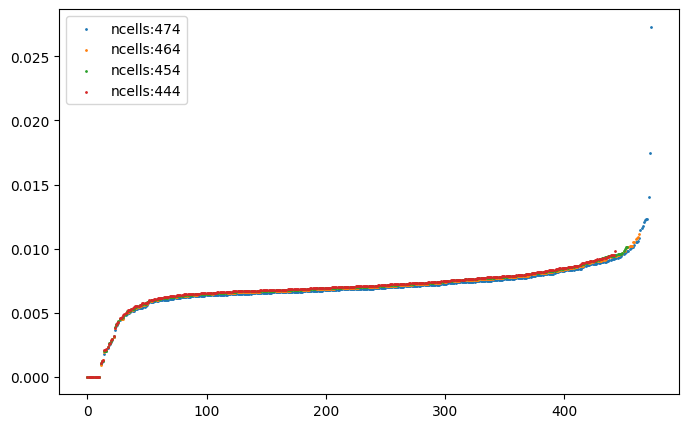

In [11]:
path=(f'/envau/work/invibe/USERS/LOSADA/Users/losadac/decoder')
fig,ax=plt.subplots(figsize=(8,5))
for ncells in [474,464,454,444]:
    for to_decode in ['orient']:   
        res = Results.from_python_hdf5(f'{path}/{ncells}cells_c0.001_test_orient.h5')

        ax.scatter(range(len(res.list_mean_w)),res.list_mean_w,s=1,label=f'ncells:{res.n_cells}')
ax.legend()

### Prepeare data for decoding

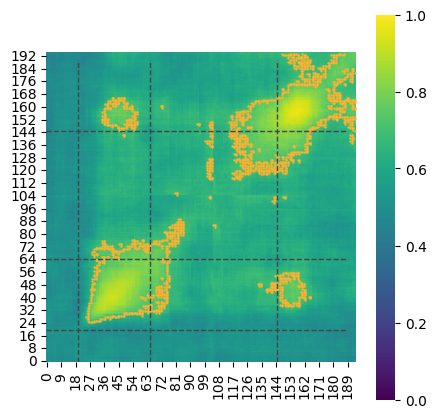

In [12]:
f,ax=plt.subplots(figsize=(5,5))
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
sns.heatmap(mean_data,ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)
xx,yy=define_contour_latencies(lat_data, thresh=95)

ax.scatter(xx,yy,s=0.5,color = '#F9B233')
ax.axes.invert_yaxis()
ax.vlines([20,65],0,190,'#444444','--',linewidth=1)
ax.hlines([20,65],0,190,'#444444','--',linewidth=1)
# ax.vlines([105],0,190,'white',linewidth=3)
# ax.hlines([105],0,190,'white',linewidth=3)
ax.vlines([145],0,190,'#444444','--',linewidth=1)
ax.hlines([145],0,190,'#444444','--',linewidth=1)

In [12]:
len(res.list_mean_w)

474

In [13]:
res.list_n_cells

array([474, 469, 464, 459, 454, 449, 444, 439, 434, 429], dtype=int16)

In [13]:
res=Results.from_python_hdf5('/envau/work/invibe/USERS/LOSADA/Users/losadac/decoder'+'/test_orientation.h5')

In [14]:
res.list_mean_w[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float16)

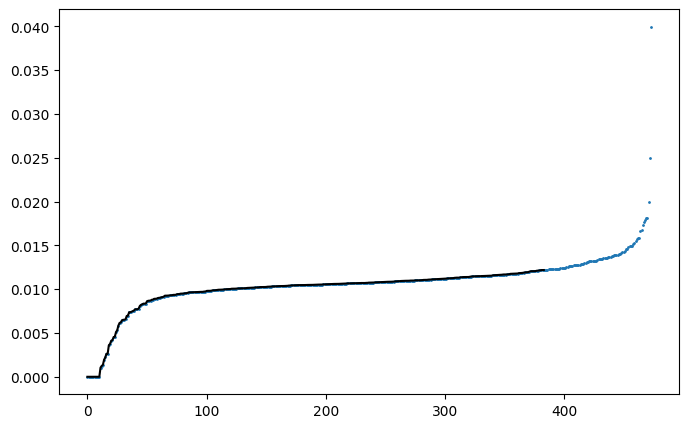

In [15]:
fig,ax=plt.subplots(figsize=(8,5))
ax.scatter(range(len(res.list_mean_w)),res.list_mean_w,s=1)
ax.plot(res.list_mean_w[:384],color='k')

In [16]:
plt.close()

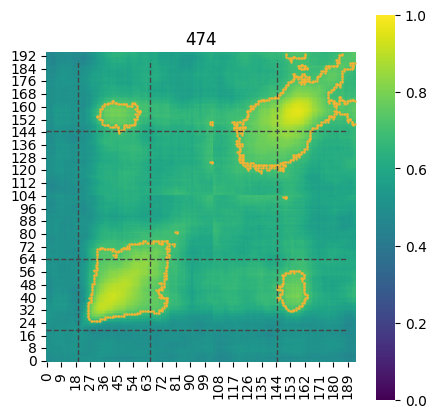

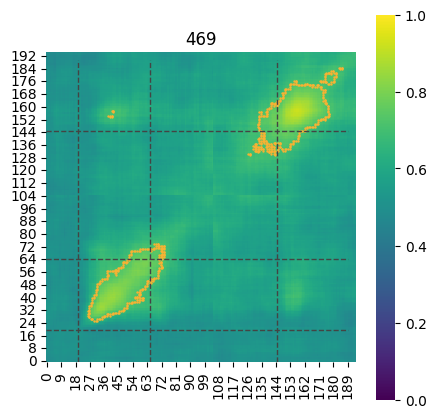

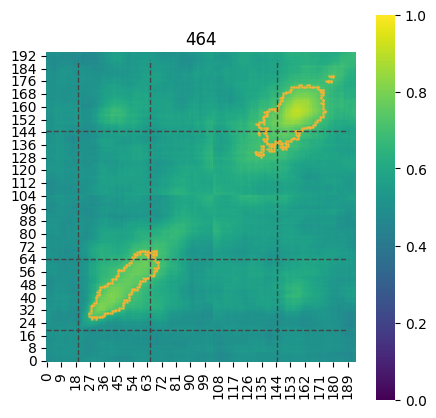

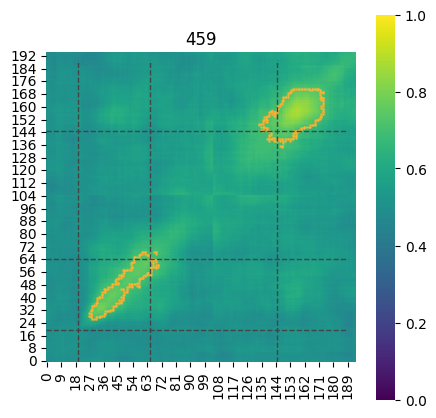

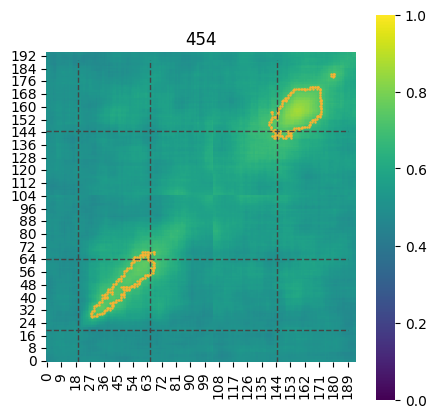

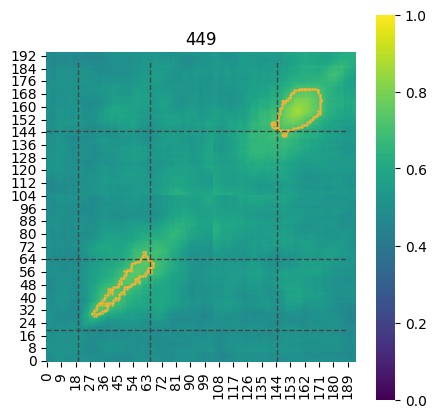

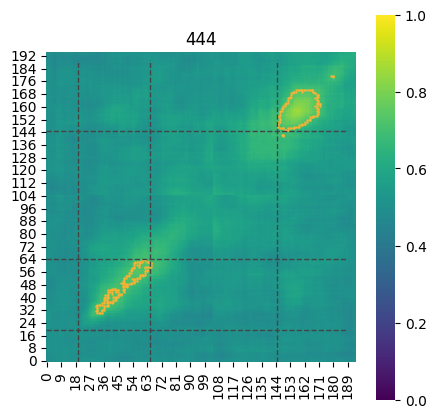

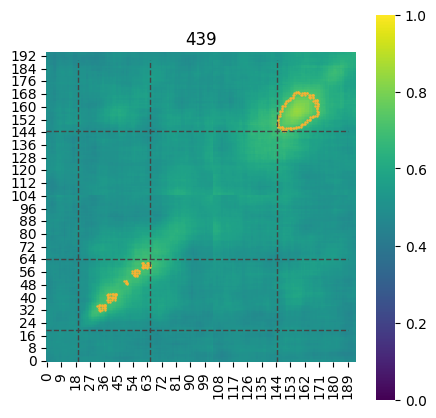

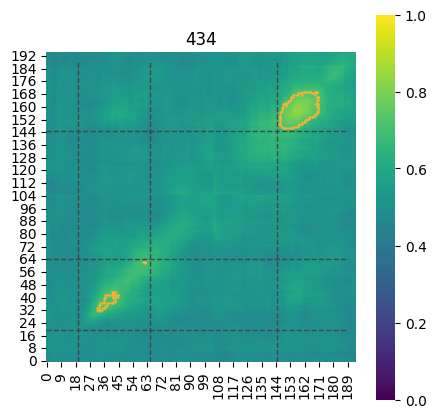

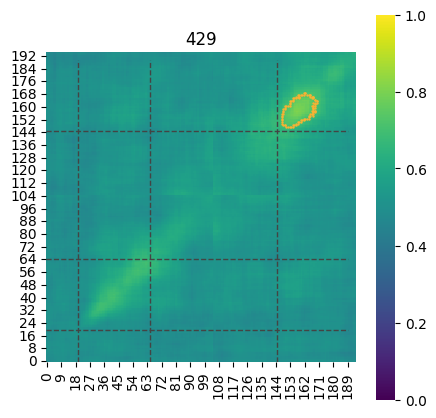

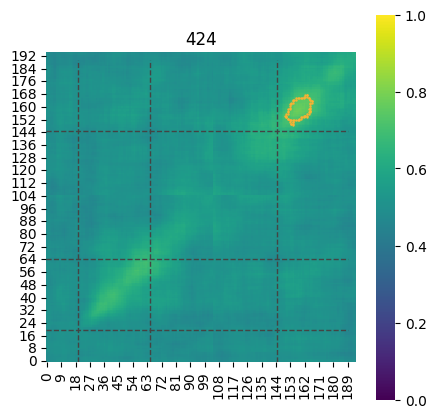

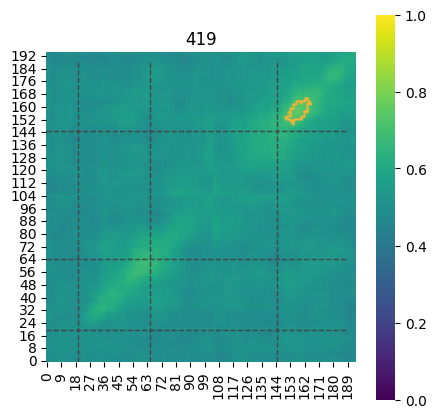

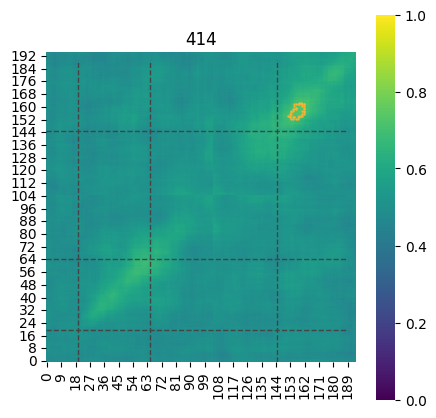

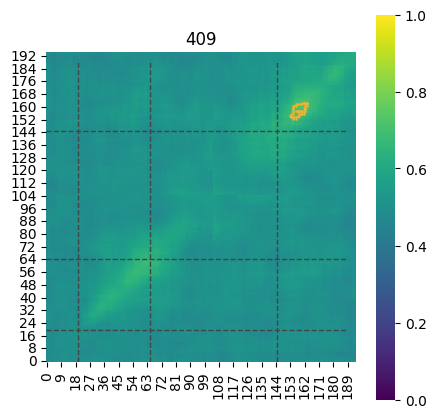

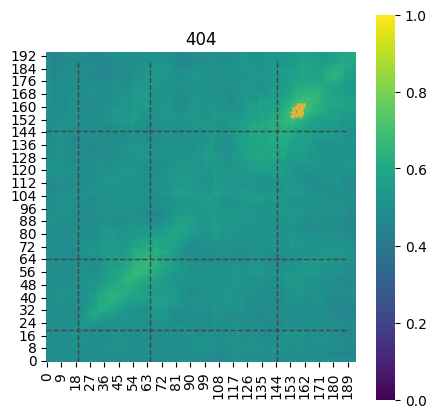

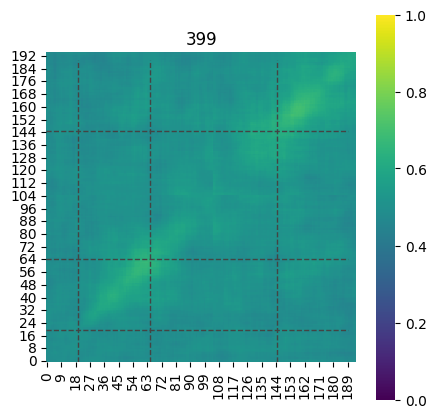

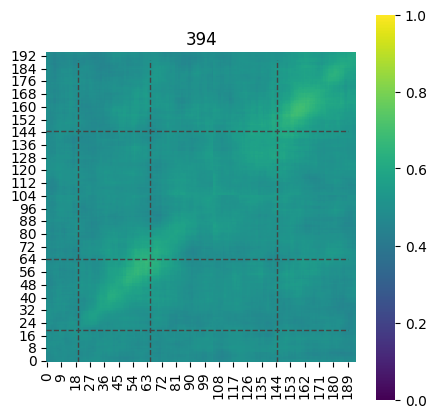

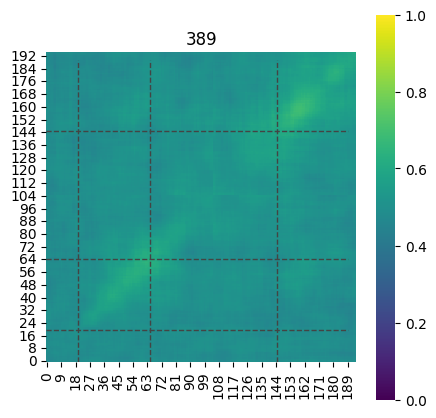

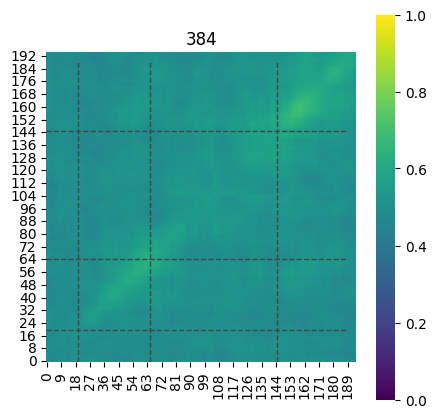

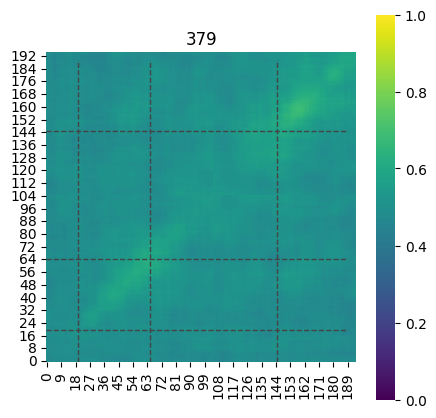

In [20]:
for i,(lat_data,mean_data) in enumerate(zip(res.lat_data,res.mean_data)):
    f,ax=plt.subplots(figsize=(5,5))
    ticks= [20,65,145,190]
    label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
    sns.heatmap(mean_data,ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)
    xx,yy=define_contour_latencies(lat_data, thresh=950)

    ax.scatter(xx,yy,s=0.5,color = '#F9B233')
    ax.axes.invert_yaxis()
    ax.vlines([20,65],0,190,'#444444','--',linewidth=1)
    ax.hlines([20,65],0,190,'#444444','--',linewidth=1)
    # ax.vlines([105],0,190,'white',linewidth=3)
    # ax.hlines([105],0,190,'white',linewidth=3)
    ax.vlines([145],0,190,'#444444','--',linewidth=1)
    ax.hlines([145],0,190,'#444444','--',linewidth=1)
    ax.set_title(res.list_n_cells[i])

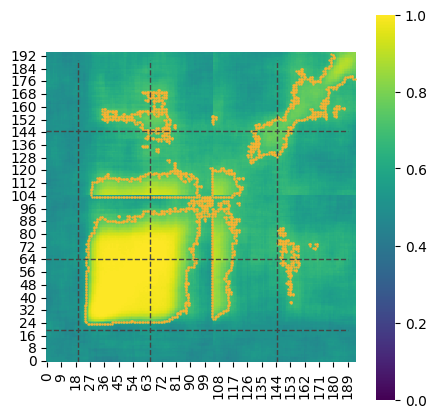